## Import libraries

In [16]:
import pdfplumber
import pandas as pd
import json
import re
from fuzzywuzzy import fuzz

## Useful functions

In [17]:
def extract_word_positions(pdf_path, i):
    '''
    Extract words with their positions from a specific page of a PDF file.
    
    Input:
    pdf_path (str): The file path to the PDF document.
    i (int): The page number to extract words from (0-indexed).
    
    Output:
    words_df (DataFrame): DataFrame containing words and their positions on the specified page.
    '''
    
    with pdfplumber.open(pdf_path) as pdf:
        page = pdf.pages[i]
        words = page.extract_words()
        words_df = pd.DataFrame(words)
    return words_df

In [18]:
def extract_cols(words_df, coordinate_param, round_param):
    '''
    Extract columns based on x0 or x1 coordinates and calculate min and max positions.

    Input:
    words_df (DataFrame): containing words and their positions.
    coordinate_param (str): The coordinate to group by ('x0' or 'x1').
    round_param (int): The degree to which the coordinates should be rounded.

    Output:
    result_df (DataFrame): containing the group names (x0 or x1), min_bottom, and max_top for each group.
    '''

    words_df2 = words_df.copy()
        
    words_df2 = words_df2[words_df2['x0'] > 50]
    words_df2['x0'] = round(words_df2['x0'], round_param)
    
    if coordinate_param == 'x0':
        # based on x0:
        grouped = words_df2.groupby('x0')

    elif coordinate_param == 'x1':
        grouped = words_df2.groupby('x1')

        # Initialize lists to store the results
    min_bottoms = []
    max_tops = []
    group_names = []

    # Iterate over each group
    for name, group in grouped:
        if len(group) > 3:
            # Calculate the min of 'bottom' and max of 'top' for the group
            min_bottom = group['bottom'].max()
            max_top = group['top'].min()

            # Append the results to the lists
            group_names.append(name)
            min_bottoms.append(min_bottom)
            max_tops.append(max_top)

    # Create a new DataFrame with the results
    result_df = pd.DataFrame({
        coordinate_param: group_names,
        'min_bottom': min_bottoms,
        'max_top': max_tops
    })

    return result_df

In [19]:
# import pandas as pd

# def extract_cols(words_df, coordinate_param, round_param, threshold = 5):
#     '''
#     Extract columns based on x0 or x1 coordinates and calculate min and max positions.

#     Input:
#     words_df (DataFrame): containing words and their positions.
#     coordinate_param (str): The coordinate to group by ('x0' or 'x1').
#     round_param (int): The degree to which the coordinates should be rounded.

#     Output:
#     result_df (DataFrame): containing the group names (x0 or x1), min_bottom, and max_top for each group.
#     '''

#     words_df2 = words_df.copy()
        
#     words_df2 = words_df2[words_df2['x0'] > 50]
#     words_df2['x0'] = round(words_df2['x0'], round_param)
    
#     if coordinate_param == 'x0':
#         # based on x0:
#         grouped = words_df2.groupby('x0')

#     elif coordinate_param == 'x1':
#         grouped = words_df2.groupby('x1')

#         # Initialize lists to store the results
#     min_bottoms = []
#     max_tops = []
#     group_names = []

#     # Iterate over each group
#     for name, group in grouped:
#         if len(group) > 3:
#             # Calculate the min of 'bottom' and max of 'top' for the group
#             min_bottom = group['bottom'].max()
#             max_top = group['top'].min()

#             # Append the results to the lists
#             group_names.append(name)
#             min_bottoms.append(min_bottom)
#             max_tops.append(max_top)

#     # Create a new DataFrame with the results
#     result_df = pd.DataFrame({
#         coordinate_param: group_names,
#         'min_bottom': min_bottoms,
#         'max_top': max_tops
#     })

#     # print(result_df)
#     # Function to find values within a threshold
#     def find_repeated_pairs_within_threshold(min_bottoms, max_tops, threshold):
#         repeated_pairs = []
#         count_dict = {}
        
#         for i in range(len(min_bottoms)):
#             for j in range(i + 1, len(min_bottoms)):
#                 if abs(min_bottoms[i] - min_bottoms[j]) <= threshold and abs(max_tops[i] - max_tops[j]) <= threshold:
#                     pair_i = (min_bottoms[i], max_tops[i])
#                     pair_j = (min_bottoms[j], max_tops[j])
#                     count_dict[pair_i] = count_dict.get(pair_i, 0) + 1
#                     count_dict[pair_j] = count_dict.get(pair_j, 0) + 1

#         for pair, count in count_dict.items():
#             if count >= 3:  # Since we are counting pairs, count >= 2 means the pair appears at least 3 times
#                 repeated_pairs.append(pair)
                
#         return repeated_pairs

#     # Find repeated min_bottom and max_top pairs within the threshold
#     repeated_pairs = find_repeated_pairs_within_threshold(result_df['min_bottom'].values, result_df['max_top'].values, threshold)

#     # Filter the dataframe based on the repeated pairs
#     filtered_df = result_df[result_df.apply(lambda row: (row['min_bottom'], row['max_top']) in repeated_pairs, axis=1)]
    
#     return filtered_df

In [20]:
def complexe_word(words_df, round_param):

    '''
    Merge adjacent words in a DataFrame if they meet certain criteria.

    Input:
    words_df (DataFrame): DataFrame containing words and their positions.
    round_param (int): The degree to which the coordinates should be rounded.

    Output:
    merged_df (DataFrame): A DataFrame containing merged words and their updated positions.
    '''

    words_df2 = words_df.copy()
    words_df2['x0'] = words_df2['x0'].round(round_param)
    words_df2['x1'] = words_df2['x1'].round(round_param)

    merged_words = []
    i = 0

    while i < len(words_df2):
        w1 = words_df2.iloc[i].to_dict()
        j = i + 1

        while j < len(words_df2):
            w2 = words_df2.iloc[j].to_dict()
            if w1['x0'] < w2['x0'] and w2['x0'] - w1['x1'] < 4 and w1['bottom'] == w2['bottom']:
                # Merge w1 and w2
                w1['text'] = f"{w1['text']} {w2['text']}"
                w1['x1'] = w2['x1']
                w1['top'] = min(w1['top'], w2['top'])
                w1['doctop'] = min(w1['doctop'], w2['doctop'])  # the top coordinate of the word relative to the entire document 
                w1['bottom'] = max(w1['bottom'], w2['bottom'])
                w1['upright'] = w1['upright'] and w2['upright']
                w1['height'] = max(w1['height'], w2['height'])
                w1['width'] = w2['x1'] - w1['x0']
                w1['direction'] = w1['direction']
                j += 1
            else:
                break

        merged_words.append(w1)
        i = j

    merged_df = pd.DataFrame(merged_words)
    return merged_df

In [21]:
def extract_largest_text(pdf_path, page):
    '''extract the titles from pages 34 to 205 
    
    Extract the largest text elements (titles) from a specified page in a PDF document.

    Input:
    pdf_path (str): The file path to the PDF document.
    page (int): The page number from which to extract the largest text elements (0-indexed).

    Output:
    max_size_elements_df (DataFrame): containing the text elements with the largest font size on the specified page.
    '''
    words_df = extract_word_positions(pdf_path, page)

    max_size = words_df['height'].max()
    max_size_elements_df = words_df[(words_df['height'] <= max_size) &\
                                    (words_df['height'] > max_size - 1.6) &\
                                    (words_df['bottom'] <= 70)]

    merged_max_size_elements_df = complexe_word(max_size_elements_df, round_param=1)

    return merged_max_size_elements_df

In [22]:
# extract_largest_text(pdf_path, 45)
# extract_largest_text(pdf_path, 33)

In [23]:
def match_element_in_text(materials, title):
    """
    Match the material to the titles
    """
    title = title.lower()  # Convert text to lowercase for case-insensitive matching
    for material in materials:
        if re.search(re.escape(material.lower()), title):
            return material
    return None

In [24]:
def extract_positions_for_elements(pdf_path, material_pages):   ## to change!!! 7yed dik aprasssive, then element_name!
    
  """
    Extract the positions of text elements from specified pages in a PDF document.

    Input:
    pdf_path (str): The file path to the PDF document.
    material_pages (dict): A dictionary where the keys are material names and the values are lists of page numbers.

    Output:
    content (dict): A dictionary where the keys are material names, and the values contain:
                    - 'pages_num': A list of page numbers.
                    - 'pages_content': A list of DataFrames containing the content for each page.
                    - 'remarks': A list of remarks (initially empty).
                    - 'tables': A list of tables (initially empty).
    """
  content = {}
  
  for material, pages in material_pages.items():
      content[material] = {
            'pages_num': pages,
            'pages_content': [],
            'remarks': [],
            'tables': []
        }
      for i, page_number in enumerate(pages):
            page_content = extract_word_positions(pdf_path, page_number - 1)
            content[material]['pages_content'].append(page_content) 
          
  return content

In [25]:
# def extract_parentheses_text(df, pdf_path, page, bottom = 82): 
  
#   '''
#     Extract text within parentheses from specified sections of a PDF document.

#     Input:
#     df (DataFrame): DataFrame containing text elements and their positions.
#     pdf_path (str): The file path to the PDF document.
#     page (int): The page number from which to extract the text (0-indexed).
#     bottom (int, optional): The bottom coordinate threshold for filtering text elements. Default is 82.

#     Output:
#     parentheses_texts (list): A list of strings containing the text found within parentheses.
#     '''

#   title_bottom = extract_largest_text(pdf_path, page)['bottom'].max()
      
#       # Filter the elements based on the top value
#   filtered_elements = df[
#       (df['top'] < bottom) &
#       (df['top'] > title_bottom)
#   ]
#   print(filtered_elements)
  
#   # Extract text within parentheses from the filtered elements
#   parentheses_texts = []
#   capture = False
#   current_text = ""
  
#   for index, row in filtered_elements.iterrows():
#       text = row['text']
#       if '(' in text:
#           capture = True
#       if capture:
#           current_text += text + " "
#       if ')' in text:
#           capture = False
#           parentheses_texts.append(current_text.strip())
#           current_text = ""
  
#   return parentheses_texts

In [60]:
def extract_parentheses_text(df, pdf_path, page, bottom=82):
    '''
    Extract text within parentheses from specified sections of a PDF document along with their bounding boxes.

    Input:
    df (DataFrame): DataFrame containing text elements and their positions.
    pdf_path (str): The file path to the PDF document.
    page (int): The page number from which to extract the text (0-indexed).
    bottom (int, optional): The bottom coordinate threshold for filtering text elements. Default is 82.

    Output:
    result_df (DataFrame): DataFrame containing the text found within parentheses and their bounding boxes.
    '''

    # Assuming extract_largest_text is a predefined function that extracts the largest text element on the page
    title_bottom = extract_largest_text(pdf_path, page)['bottom'].max()
      
    # Filter the elements based on the top value
    filtered_elements = df[
        (df['top'] < bottom) &
        (df['top'] > title_bottom)
    ]

    # Extract text within parentheses from the filtered elements
    rows = []
    capture = False
    current_text = ""
    min_x0, max_x1, min_top, max_bottom = float('inf'), 0, float('inf'), 0
    directions, heights, widths = set(), set(), set()
    
    for index, row in filtered_elements.iterrows():
        text = row['text']
        if '(' in text:
            capture = True
        if capture:
            current_text += text + " "
            min_x0 = min(min_x0, row['x0'])
            max_x1 = max(max_x1, row['x1'])
            min_top = min(min_top, row['top'])
            max_bottom = max(max_bottom, row['bottom'])
            directions.add(row['direction'])
            heights.add(row['height'])
            widths.add(row['width'])
        if ')' in text:
            capture = False
            rows.append({
                'text': current_text.strip(),
                'x0': min_x0,
                'x1': max_x1,
                'top': min_top,
                'bottom': max_bottom,
                'doctop': None,  # doctop can be set to None or computed if needed
                'upright': True,  # Assuming upright is always True
                'height': max(heights),  # Assuming you want the maximum height
                'width': sum(widths),  # Sum of widths, if they are contiguous
                'direction': directions.pop() if len(directions) == 1 else list(directions)
            })
            current_text = ""
            min_x0, max_x1, min_top, max_bottom = float('inf'), 0, float('inf'), 0
            directions, heights, widths = set(), set(), set()

    result_df = pd.DataFrame(rows)
    return result_df

## TEST functions

In [27]:
pdf_path = "mcs2024.pdf"

In [28]:
extract_largest_text(pdf_path, 45)

,text,x0,x1,top,doctop,bottom,upright,height,width,direction
0,BAUXITE AND ALUMINA1,233.5,378.6,35.82048,33334.15404,49.332,True,13.51152,145.1,ltr


## Extract the material lists

In [29]:
df = extract_word_positions(pdf_path, 0)
complexe_df = complexe_word(df, 2)

complexe_df.sample(2)

,text,x0,x1,top,doctop,bottom,upright,height,width,direction
43,Helium,195.85,230.52,458.730,458.730,470.730,True,12.0,34.668,ltr
78,Diamond,74.31,117.64,588.378,588.378,600.378,True,12.0,43.332,ltr


In [30]:
# df[df['text'].isin(['Sand', 'and', 'Gravel'])]

# complexe_df[complexe_df['text'] == 'Sand and Gravel']

In [31]:
# result_df = extract_cols(df, 'x0', 2)

result_df = extract_cols(complexe_df, 'x0', 2)

In [32]:
result_df

,x0,min_bottom,max_top
0,74.31,629.178,329.178
1,195.85,629.130,329.130
2,318.85,629.130,329.130
3,439.84,629.130,329.130


In [33]:
result_df['max_top'].min()

np.float64(329.12999999999954)

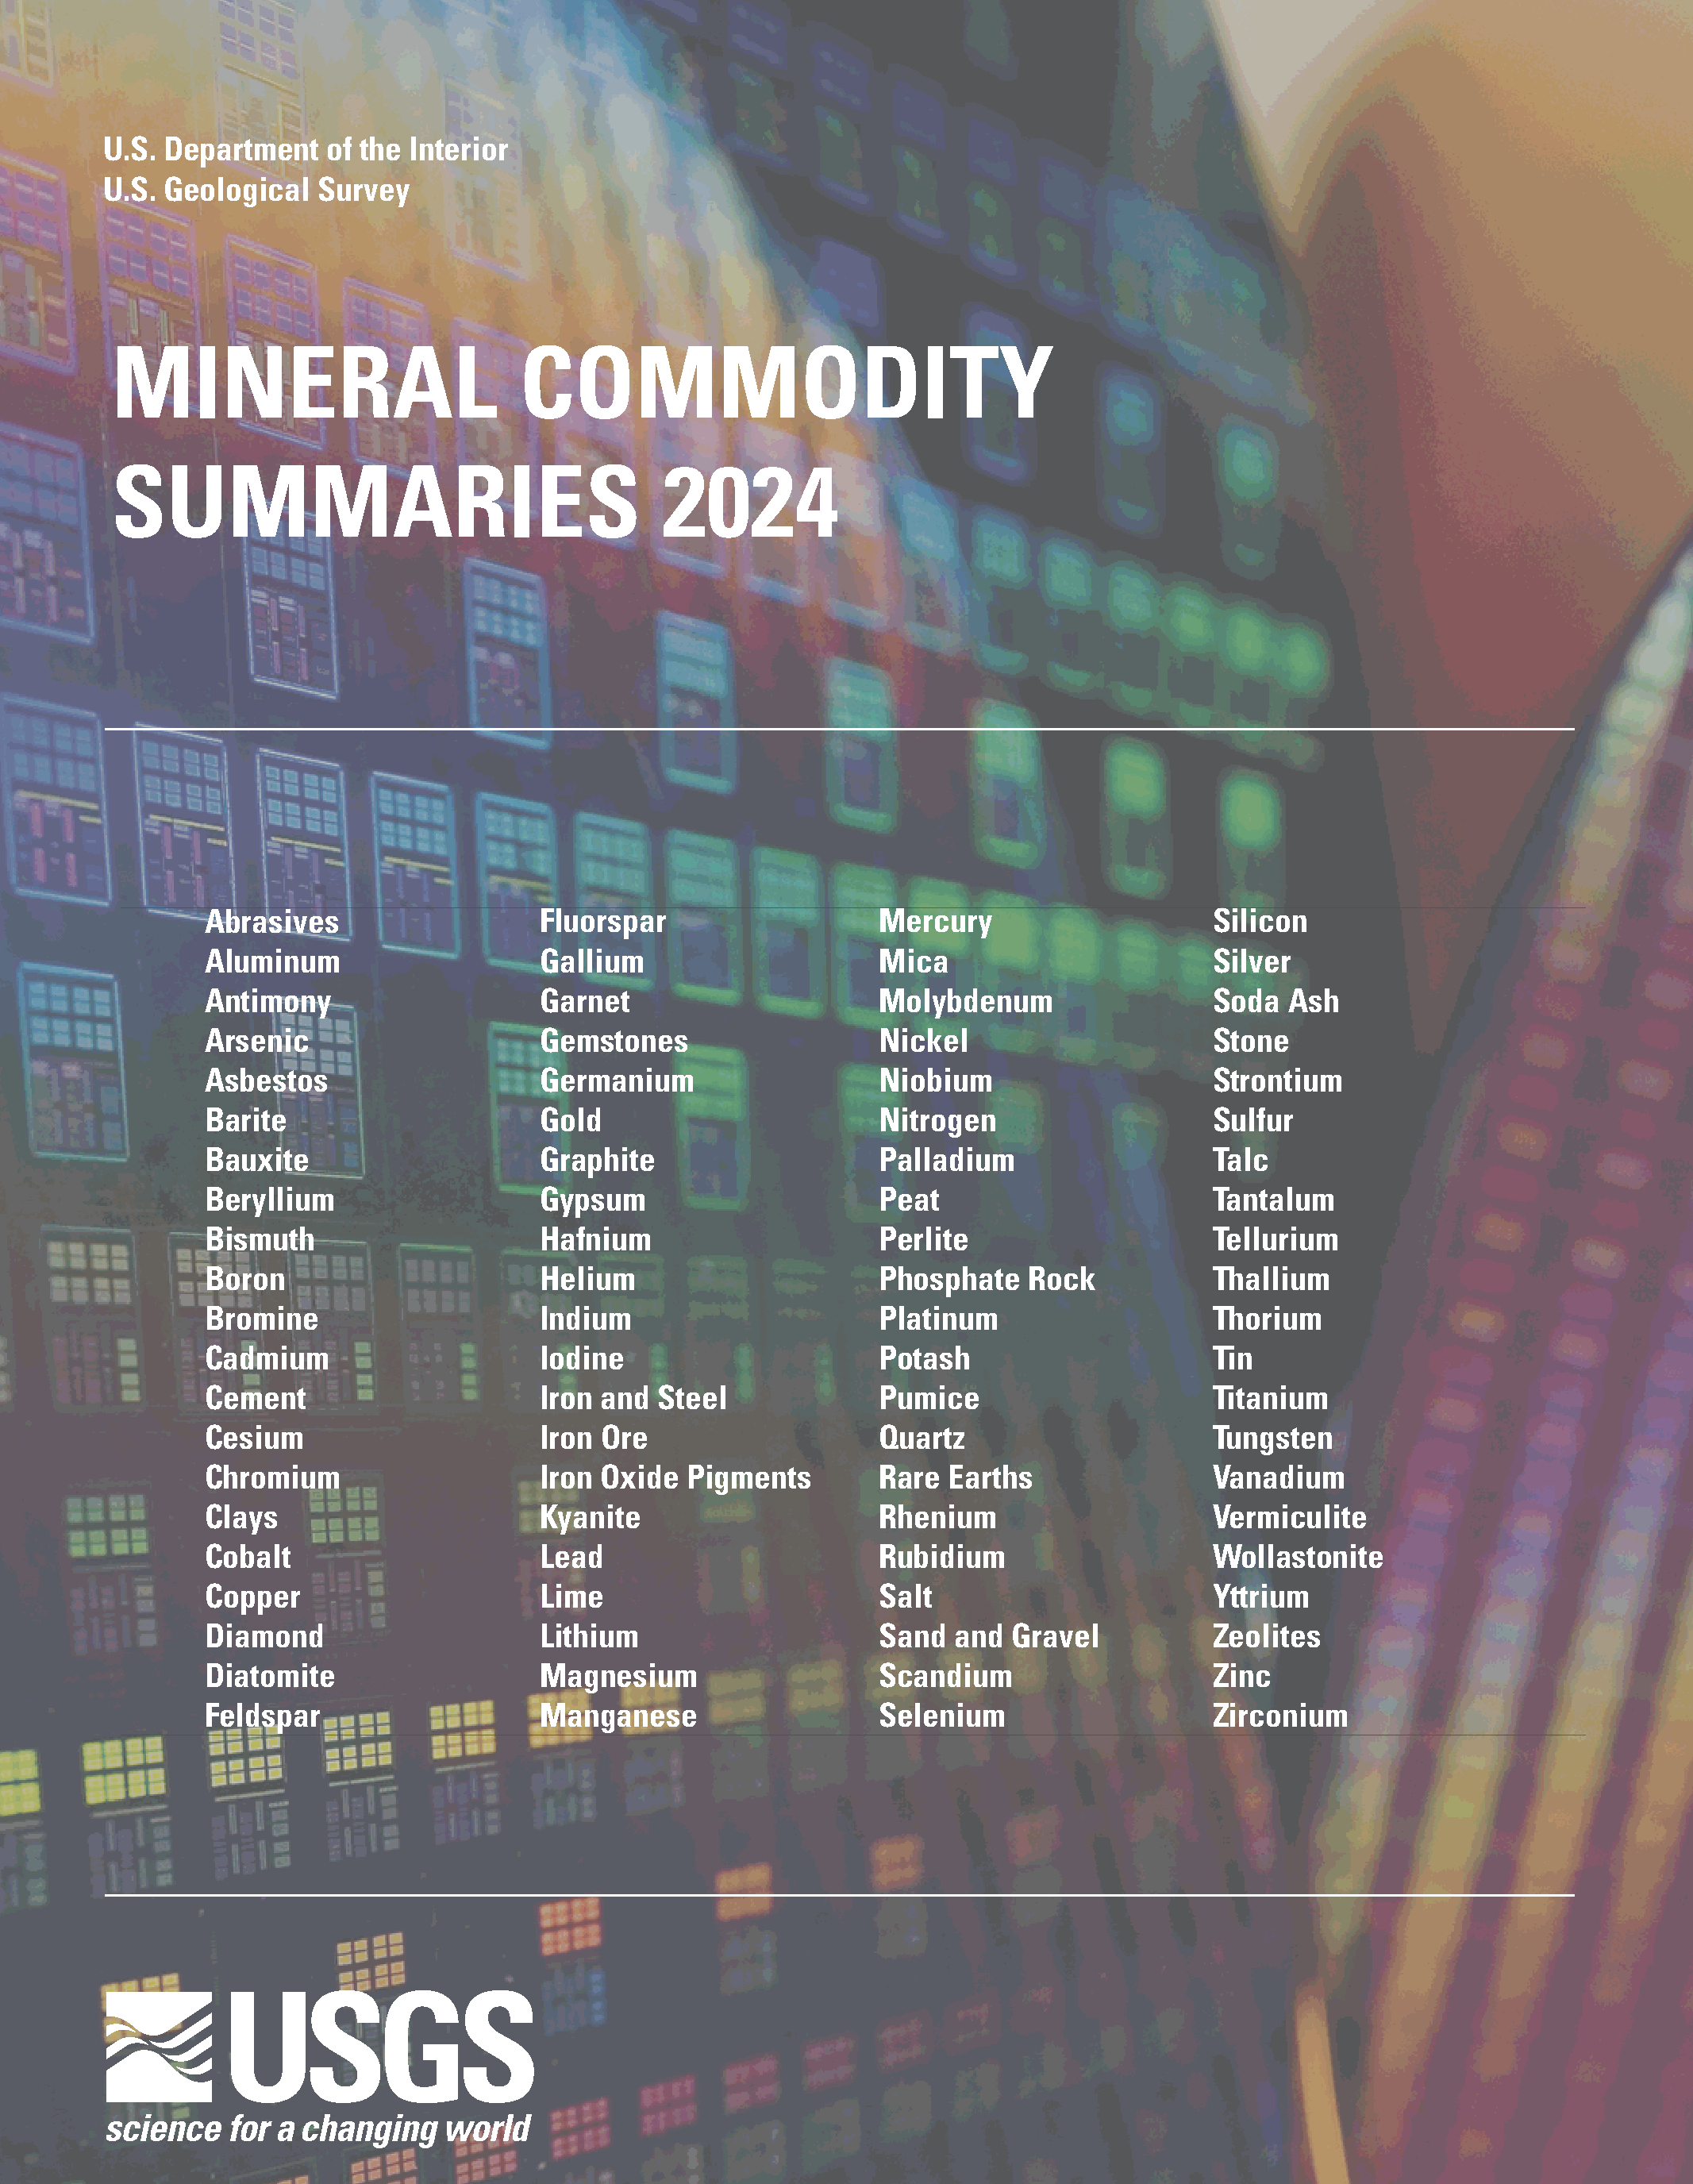

In [34]:
import pdfplumber

with pdfplumber.open("mcs2024.pdf") as pdf:
    im = pdf.pages[0].to_image(resolution=250)

im.draw_line([(575, result_df['max_top'].min()), (44, result_df['max_top'].min())], )
im.draw_line([(575, result_df['min_bottom'].max()), (44, result_df['min_bottom'].max())], )

In [35]:
materials_list = complexe_df[(complexe_df['top'] > int(result_df['max_top'].min())) & (complexe_df['bottom'] < 630)]['text'].tolist()

len(materials_list)

84

In [36]:
materials_list

['Abrasives',
 'Fluorspar',
 'Mercury',
 'Silicon',
 'Aluminum',
 'Gallium',
 'Mica',
 'Silver',
 'Antimony',
 'Garnet',
 'Molybdenum',
 'Soda Ash',
 'Arsenic',
 'Gemstones',
 'Nickel',
 'Stone',
 'Asbestos',
 'Germanium',
 'Niobium',
 'Strontium',
 'Barite',
 'Gold',
 'Nitrogen',
 'Sulfur',
 'Bauxite',
 'Graphite',
 'Palladium',
 'Talc',
 'Beryllium',
 'Gypsum',
 'Peat',
 'Tantalum',
 'Bismuth',
 'Hafnium',
 'Perlite',
 'Tellurium',
 'Boron',
 'Helium',
 'Phosphate Rock',
 'Thallium',
 'Bromine',
 'Indium',
 'Platinum',
 'Thorium',
 'Cadmium',
 'Iodine',
 'Potash',
 'Tin',
 'Cement',
 'Iron and Steel',
 'Pumice',
 'Titanium',
 'Cesium',
 'Iron Ore',
 'Quartz',
 'Tungsten',
 'Chromium',
 'Iron Oxide Pigments',
 'Rare Earths',
 'Vanadium',
 'Clays',
 'Kyanite',
 'Rhenium',
 'Vermiculite',
 'Cobalt',
 'Lead',
 'Rubidium',
 'Wollastonite',
 'Copper',
 'Lime',
 'Salt',
 'Yttrium',
 'Diamond',
 'Lithium',
 'Sand and Gravel',
 'Zeolites',
 'Diatomite',
 'Magnesium',
 'Scandium',
 'Zinc',
 'F

In [37]:
'Tin' in materials_list

True

In [38]:
with open('json_files\materials_list.json', 'w') as json_file:
    json.dump(materials_list, json_file)

## Match each material with its pages

In [39]:
# # Ouvrir le PDF
# elements = materials_list

# with pdfplumber.open(pdf_path) as pdf:
#     # Dictionnaire pour stocker les pages correspondant à chaque élément
#     pdf_sections = {material: [] for material in materials_list}
    
#     # Parcourir chaque page du PDF
#     for i in range(33, 209):
#         # page = pdf.pages[i]
#         largest_text = extract_largest_text(pdf_path, i)
        
#         # 1 word
#         title = complexe_word(largest_text, 2)
#         print(title)

#         # for text in title:
#         #     matched_element = match_element_in_text(materials_list, text)
#         #     if matched_element:
#         #         pdf_sections[matched_element].append(i + 1)  # Pages are indexed from 1 in PDFs

In [40]:
# Ouvrir le PDF
elements = materials_list

with pdfplumber.open(pdf_path) as pdf:
    # Dictionnaire pour stocker les pages correspondant à chaque élément
    pdf_sections = {material: {'title': '', 'pages': []} for material in materials_list}
    
    # Parcourir chaque page du PDF
    for i in range(33, 209):
        # page = pdf.pages[i]
        largest_text = extract_largest_text(pdf_path, i)['text'].to_list()

        print(f'▶️ Largest_text: {largest_text}')

        for text in largest_text:
            matched_element = match_element_in_text(materials_list, text)
            if matched_element:
                pdf_sections[matched_element]['title'] = largest_text
                pdf_sections[matched_element]['pages'].append(i + 1)

▶️ Largest_text: ['ABRASIVES (MANUFACTURED)']
▶️ Largest_text: ['ABRASIVES (MANUFACTURED)']
▶️ Largest_text: ['ALUMINUM1']
▶️ Largest_text: ['ALUMINUM']
▶️ Largest_text: ['ANTIMONY']
▶️ Largest_text: ['ANTIMONY']
▶️ Largest_text: ['ARSENIC']
▶️ Largest_text: ['ARSENIC']
▶️ Largest_text: ['ASBESTOS']
▶️ Largest_text: ['ASBESTOS']
▶️ Largest_text: ['BARITE']
▶️ Largest_text: ['BARITE']
▶️ Largest_text: ['BAUXITE AND ALUMINA1']
▶️ Largest_text: ['BAUXITE AND ALUMINA']
▶️ Largest_text: ['BERYLLIUM']
▶️ Largest_text: ['BERYLLIUM']
▶️ Largest_text: ['BISMUTH']
▶️ Largest_text: ['BISMUTH']
▶️ Largest_text: ['BORON']
▶️ Largest_text: ['BORON']
▶️ Largest_text: ['BROMINE']
▶️ Largest_text: ['BROMINE']
▶️ Largest_text: ['CADMIUM']
▶️ Largest_text: ['CADMIUM']
▶️ Largest_text: ['CEMENT']
▶️ Largest_text: ['CEMENT']
▶️ Largest_text: ['CESIUM']
▶️ Largest_text: ['CESIUM']
▶️ Largest_text: ['CHROMIUM']
▶️ Largest_text: ['CHROMIUM']
▶️ Largest_text: ['CLAYS']
▶️ Largest_text: ['CLAYS']
▶️ Largest_tex

KeyboardInterrupt: 

In [ ]:
pdf_sections

{'Abrasives': [34, 35],
 'Fluorspar': [76, 77],
 'Mercury': [122, 123],
 'Silicon': [164, 165],
 'Aluminum': [36, 37],
 'Gallium': [78, 79],
 'Mica': [124, 125],
 'Silver': [166, 167],
 'Antimony': [38, 39],
 'Garnet': [80, 81],
 'Molybdenum': [126, 127],
 'Soda Ash': [168, 169],
 'Arsenic': [40, 41],
 'Gemstones': [82, 83],
 'Nickel': [128, 129],
 'Stone': [170, 171, 172, 173],
 'Asbestos': [42, 43],
 'Germanium': [84, 85],
 'Niobium': [130, 131],
 'Strontium': [174, 175],
 'Barite': [44, 45],
 'Gold': [86, 87],
 'Nitrogen': [132, 133],
 'Sulfur': [176, 177],
 'Bauxite': [46, 47],
 'Graphite': [88, 89],
 'Palladium': [],
 'Talc': [178, 179],
 'Beryllium': [48, 49],
 'Gypsum': [90, 91],
 'Peat': [134, 135],
 'Tantalum': [180, 181],
 'Bismuth': [50, 51],
 'Hafnium': [208, 209],
 'Perlite': [136, 137],
 'Tellurium': [182, 183],
 'Boron': [52, 53],
 'Helium': [92, 93],
 'Phosphate Rock': [138, 139],
 'Thallium': [184, 185],
 'Bromine': [54, 55],
 'Indium': [94, 95],
 'Platinum': [140, 141

In [ ]:
nombre_de_listes_vides = sum(1 for pages in pdf_sections.values() if not pages)
nombre_de_listes_vides

2

In [ ]:
empty_elements = [element for element, pages in pdf_sections.items() if not pages]

# Remove and 'Palladium' from the empty_elements list using set difference
excluded_elements = {'Palladium'}
empty_elements = list(set(empty_elements) - excluded_elements)

empty_elements

# Palladium, included in plat ✅

['Zirconium']

In [ ]:
one_page_elements = [element for element, pages in pdf_sections.items() if len(pages) == 1]

one_page_elements

[]

In [ ]:
three_page_elements = [element for element, pages in pdf_sections.items() if len(pages) == 3]

three_page_elements

[]

In [ ]:
four_page_elements = [element for element, pages in pdf_sections.items() if len(pages) == 4]

four_page_elements

['Stone', 'Titanium', 'Sand and Gravel', 'Magnesium']

In [42]:
import json

# Define the filename for the JSON file
json_filename = 'json_files/pdf_restric.json'

# Write the pdf_restric dictionary to a JSON file
with open(json_filename, 'w') as json_file:
    json.dump(pdf_restric, json_file, indent=4)

print(f"Data saved to {json_filename}")

Data saved to json_files/pdf_restric.json


## Dictionary: 
{material_name: {
'material_title': df(title, bounding box),
'pages_num': [page1, page2],
'pages_content': [dataframe1, dataframe2],
  'remarks': [remark_df],
  'tables': [[tables_1(table + bounding_box)], [tables_2(table + bounding_box)]]
  }
}

In [50]:
pdf_restric = {'Abrasives': [34, 35],}
#  'Fluorspar': [76, 77],
#  'Mercury': [122, 123],
#  'Silicon': [164, 165],
#  'Aluminum': [36, 37, 46, 47, 130, 131],
#  'Gallium': [78, 79],
#  'Mica': [124, 125],
#  'Silver': [166, 167],
#  'Antimony': [38, 39],}

# pdf_restric

In [52]:
scraping_base = extract_positions_for_elements(pdf_path, pdf_restric)

In [53]:
scraping_base['Abrasives'].keys()

dict_keys(['pages_num', 'pages_content', 'remarks', 'tables'])

## Remark extraction

In [63]:
for material, data in scraping_base.items():
#   Extract remarks from parentheses in the content of page 0
  remarks = extract_parentheses_text(data['pages_content'][0], pdf_path, data['pages_num'][0])
  data['remarks'] = remarks

  print(f"▶️ material: {material}, remark: {data['remarks']}")

▶️ material: Abrasives, remark:                                                 text         x0         x1  \
0  (Fused aluminum oxide, silicon carbide, and me...  165.66000  446.40036   
1   (Data in metric tons unless otherwise specified)  201.24102  410.79930   

        top    bottom doctop  upright  height       width direction  
0  60.07650  70.09650   None     True   10.02  261.537030       ltr  
1  71.05842  81.07842   None     True   10.02  192.948126       ltr  


In [62]:
data['remarks'].columns, data['pages_content'][0].columns

(Index(['text', 'x0', 'x1', 'top', 'bottom', 'doctop', 'upright', 'height',
        'width', 'direction'],
       dtype='object'),
 Index(['text', 'x0', 'x1', 'top', 'doctop', 'bottom', 'upright', 'height',
        'width', 'direction'],
       dtype='object'))

## Table extraction (suppose it's done)

In [57]:
scraping_base['Abrasives']['content_1']

,text,x0,x1,top,doctop,bottom,upright,height,width,direction
0,30,36.000000,44.896000,27.97200,23822.30556,35.97200,True,8.00,8.896000,ltr
1,ABRASIVES,214.320000,284.304000,37.33200,23831.66556,49.33200,True,12.00,69.984000,ltr
2,(MANUFACTURED),287.640000,397.596000,37.33200,23831.66556,49.33200,True,12.00,109.956000,ltr
3,(Fused,165.660000,196.852260,60.07650,23854.41006,70.09650,True,10.02,31.192260,ltr
4,aluminum,199.622790,242.953278,60.07650,23854.41006,70.09650,True,10.02,43.330488,ltr
...,...,...,...,...,...,...,...,...,...,...
533,W.,139.271448,151.536930,740.44752,24534.78108,750.46752,True,10.02,12.265482,ltr
534,Olson,154.271388,182.652036,740.44752,24534.78108,750.46752,True,10.02,28.380648,ltr
535,[(703),185.412546,212.088792,740.44752,24534.78108,750.46752,True,10.02,26.676246,ltr
536,"648–7721,",214.872348,262.171758,740.44752,24534.78108,750.46752,True,10.02,47.299410,ltr


In [58]:
# table bounding box
bounding_box = extract_cols(scraping_base['Abrasives']['content_1'], 'x1', 0)

bounding_box

,x1,min_bottom,max_top
0,81.952554,466.0965,214.0365
1,83.626896,477.0765,225.0765
2,88.042710,488.0565,236.0565
3,128.051568,466.0965,214.0365
4,133.638720,488.0565,236.0565
5,372.599154,719.0565,632.0565
6,374.095188,345.0765,214.0365
7,374.096208,389.0565,236.0565
8,420.175188,323.0565,214.0365
9,420.176208,389.0565,236.0565


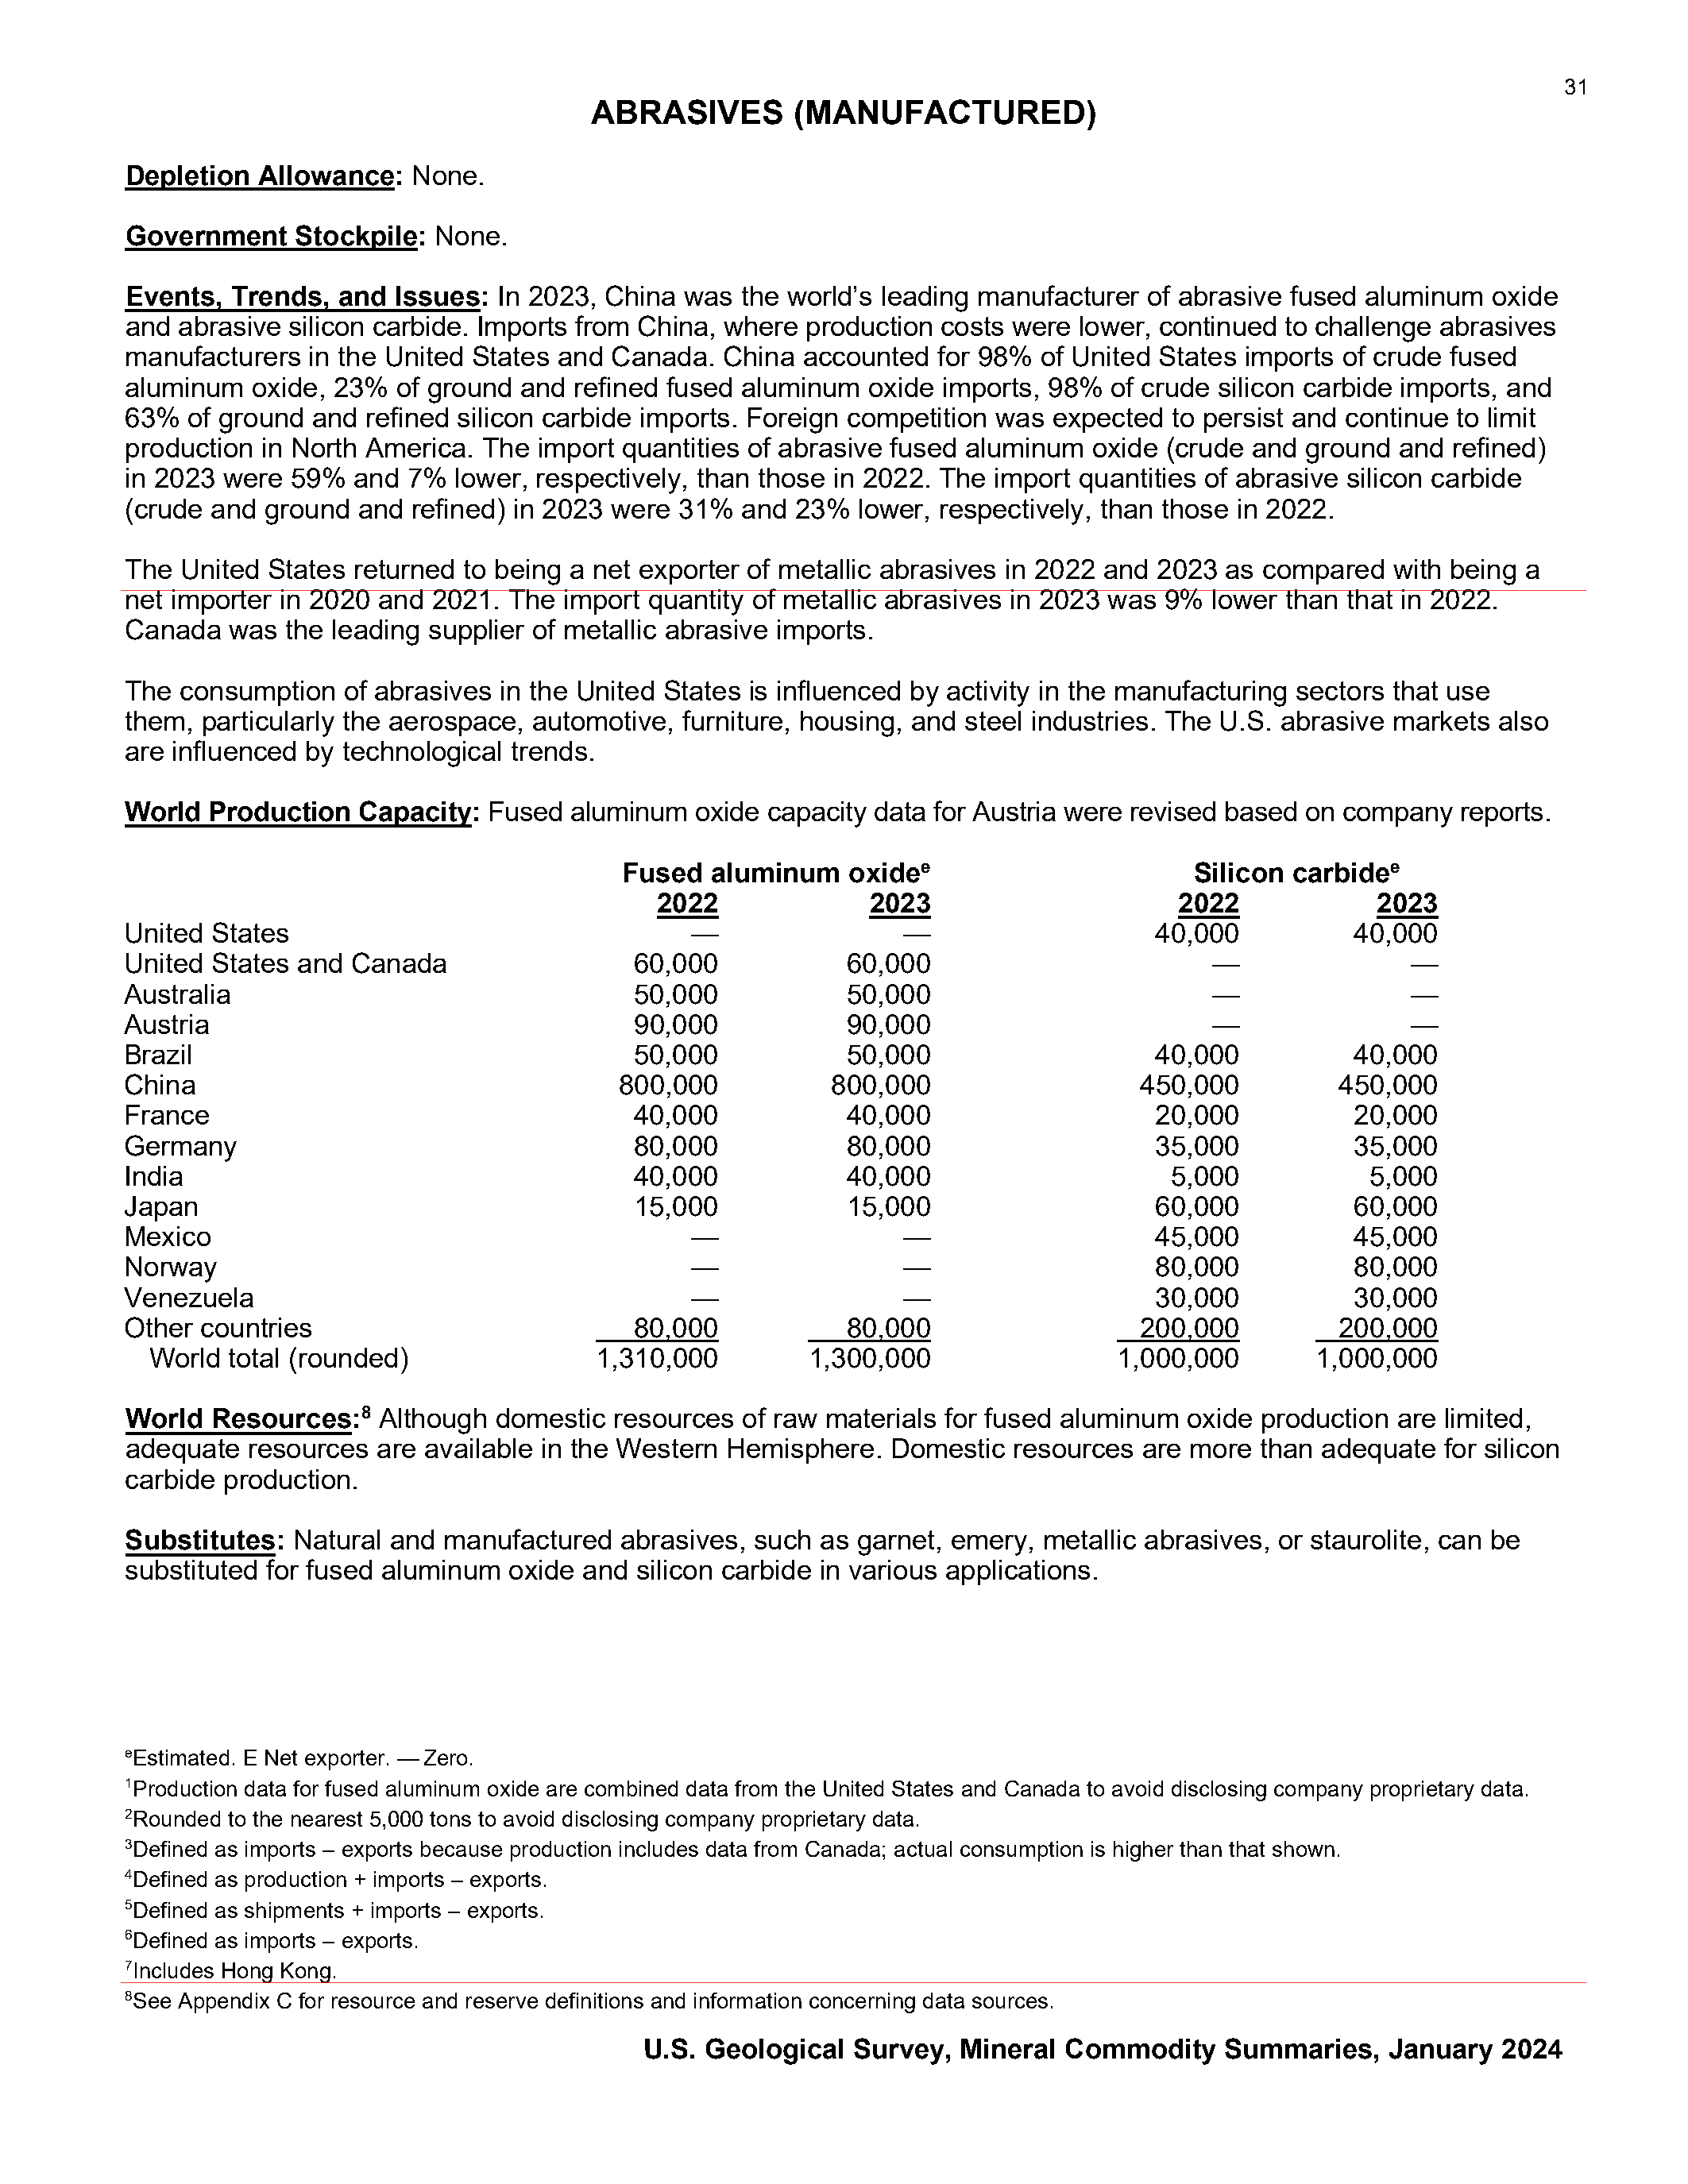

In [59]:
with pdfplumber.open("mcs2024.pdf") as pdf:
    im = pdf.pages[34].to_image(resolution=250)

im.draw_line([(575, bounding_box['max_top'].min()), (44, bounding_box['max_top'].min())], )
im.draw_line([(575, bounding_box['min_bottom'].max()), (44, bounding_box['min_bottom'].max())], )

# im.draw_line([(575, 320), (44, 320)], )
# im.draw_line([(575, 500), (44, 500)], )

In [60]:
df[(df['top'] > 320) & (df['bottom'] < 500)].to_csv('table_datawith_coords.csv', index=False)

## Dictionary to excel

In [10]:
table = pd.read_csv('test_csv/fused_aluminum_silicon_carbide.csv')

table

,Country,Fused aluminum oxide 2022,Fused aluminum oxide 2023,Silicon carbide 2022,Silicon carbide 2023
0,United States,NaN,NaN,40000.0,40000.0
1,United States and Canada,60000.0,60000.0,NaN,NaN
2,Australia,50000.0,50000.0,NaN,NaN
3,Austria,90000.0,90000.0,NaN,NaN
4,Brazil,50000.0,50000.0,40000.0,40000.0
5,China,800000.0,800000.0,450000.0,450000.0
6,France,40000.0,40000.0,20000.0,20000.0
7,Germany,80000.0,80000.0,35000.0,35000.0
8,India,40000.0,40000.0,5000.0,5000.0
9,Japan,15000.0,15000.0,60000.0,60000.0


In [99]:
for key in scraping_base.keys():
    scraping_base[key]['tables'] = [table]

In [119]:
with pd.ExcelWriter('output.xlsx', engine='openpyxl') as writer:
    for material, data in scraping_base.items():

        # Write remarks and tables in the same sheet, but separated by columns
        combined_sheet_name = f"{material}_Remarks_and_Tables"
        
        # Write remarks
        remarks_df = pd.DataFrame(data['remarks'], columns=['Remarks'])
        remarks_df.to_excel(writer, sheet_name=combined_sheet_name, startrow=0, startcol=0, index=False)

        # Write each table starting from a new column
        start_col = len(remarks_df.columns) + 2  # Adding 2 for separation
        for i, table in enumerate(data['tables']):
            table.to_excel(writer, sheet_name=combined_sheet_name, startrow=0, startcol=start_col, index=False)
            # Increment start_col by the number of columns in the table + 2 for separation
            start_col += len(table.columns) + 2

print("Excel file created successfully.")

Excel file created successfully.


## PDF visualisation

In [120]:
import fitz  # PyMuPDF

def draw_line_on_all_pages(input_pdf_path, output_pdf_path):
    # Open the existing PDF
    document = fitz.open(input_pdf_path)
    
    # Define the coordinates for the line
    x1, y1 = 72, 500  # Starting point (72 points = 1 inch from the left, y-coordinate)
    x2, y2 = 540, 500  # Ending point (7.5 inches from the left, same y-coordinate)

    # Iterate over each page
    for page_num in range(len(document)):
        page = document[page_num]
        
        # Draw a line on the page
        page.draw_line((x1, y1), (x2, y2), width=1, color=(0, 0, 0))  # Black line, width=1

    # Save the modified PDF to a new file
    document.save(output_pdf_path)
    document.close()

# Paths to input and output PDFs
input_pdf_path = "mcs2024.pdf"
output_pdf_path = "output_with_lines.pdf"

# Draw lines on all pages of the PDF
draw_line_on_all_pages(input_pdf_path, output_pdf_path)

print(f"Lines drawn on all pages of {input_pdf_path} and saved to {output_pdf_path}.")

Lines drawn on all pages of mcs2024.pdf and saved to output_with_lines.pdf.
